In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.datasets import ETTh1Dataset

In [2]:
series = ETTh1Dataset().load()

In [3]:
# Convert the dataset to a pandas DataFrame
df = series.pd_dataframe()

# Filter to keep only the "OT" parameter
df = df[['OT']]

# Convert the DataFrame back to a TimeSeries object
series = TimeSeries.from_dataframe(df)

In [4]:
series

<TimeSeries (DataArray) (date: 17420, component: 1, sample: 1)>
array([[[30.53100014]],

       [[27.78700066]],

       [[27.78700066]],

       ...,

       [[10.27099991]],

       [[ 9.77799988]],

       [[ 9.56700039]]])
Coordinates:
  * date       (date) datetime64[ns] 2016-07-01 ... 2018-06-26T19:00:00
  * component  (component) object 'OT'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [5]:
train, test = series[:-100], series[-100:]

<AxesSubplot: xlabel='date'>

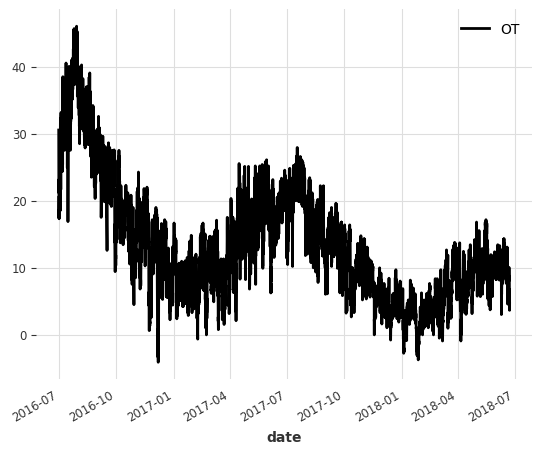

In [6]:
train.plot()

<AxesSubplot: xlabel='date'>

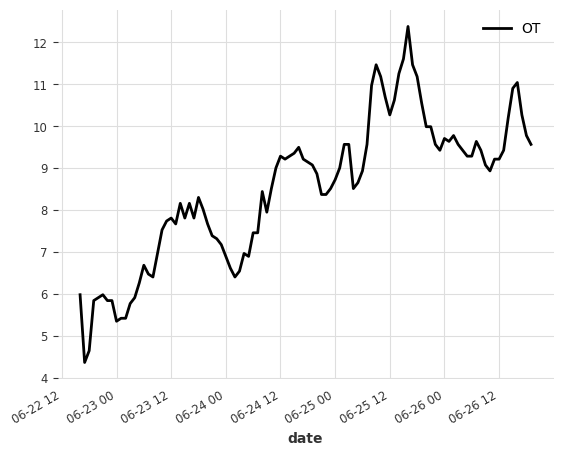

In [7]:
test.plot()

In [8]:
from darts.models.forecasting.tide_model import TiDEModel
from darts.dataprocessing.transformers import Scaler

train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

In [9]:
tide = TiDEModel(
    input_chunk_length=512, 
    output_chunk_length=100,
    num_encoder_layers=2,
    num_decoder_layers=2,
    decoder_output_dim=32,
    hidden_size=512,
    temporal_decoder_hidden=16,
    use_layer_norm=True,
    dropout=0.5,
    random_state=42)

In [10]:
tide.fit(
    scaled_train,
    epochs=5
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 1.6 M 
4 | decoders         | Sequential       | 4.3 M 
5 | temporal_decoder | _ResidualBlock   | 580   
6 | lookback_skip    | Linear           | 51.3 K
------------------------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
23.884    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
scaled_pred_tide = tide.predict(n=100)

pred_tide = train_scaler.inverse_transform(scaled_pred_tide)

In [ ]:
preds_df = pred_tide.pd_dataframe()
test_df = test.pd_dataframe()

In [ ]:
plt.plot(test_df["OT"], label='Acutal', ls='-', color='blue') 
plt.plot(preds_df["OT"], label='TiDE', ls='--', color='green')
plt.tight_layout()

In [ ]:
from darts.metrics import mae, mse

tide_mae = mae(test, pred_tide)
tide_mse = mse(test, pred_tide)

print(tide_mae, tide_mse)

In [ ]:
pred_tide_df = pred_tide.pd_dataframe()
pred_tide_df['Id'] = range(100)
pred_tide_df

In [ ]:
pred_tide_df.to_csv('predictions.csv', index=False)